In [1]:
import sys
sys.path.append("../../../")

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from experiments.assumptions.flat_output_space.script import get_euclideaness, sample_layers
from models.supervised.mlp.model import MLP
from models.data.sklearn_datasets import MoonDataset, SpiralDataset, BlobsDataset, CirclesDataset

models_path = "../../../models/supervised/mlp/saved_models"
# We want to measure the ``flatness'' of the output space of a neural network
# to then use the identity for sectional curvature as well as providing supporting
# evidence for the manifold hypothesis.

# We will use 3 methods to estimate the Riemann metric taken from https://github.com/georgiosarvanitidis/geometric_ml
# 1. Local PCA
# 2. 

In [2]:
np.random.seed(2)
torch.manual_seed(2)

In [3]:
mode = 'moon'
size = "skinny"
epoch = 199
if mode == 'moon':
    dataset = MoonDataset(n_samples=1000, noise=0.01)
elif mode == 'blobs':
    dataset = BlobsDataset(n_samples=1000, noise=0.01)
elif mode == 'spiral':
    dataset = SpiralDataset(n_samples=1000, noise=0.01)
elif mode == 'circles':
    dataset = CirclesDataset(n_samples=1000, noise=0.01)


if size == "skinny":
    model = MLP(2,7,2,2)
    full_path = f'{models_path}/2_wide/mlp_{mode}/model_{epoch}.pth'
elif size == "overfit":
    model = MLP(2,7,2,1)
    full_path = f'{models_path}/overfit/mlp_{mode}/model_{epoch}.pth'
else:
    model = MLP(2,7,10,2)
    full_path = f'{models_path}/vanilla/mlp_{mode}/model_{epoch}.pth'
model.load_state_dict(torch.load(full_path))


<All keys matched successfully>

In [4]:
res = []
for epoch in tqdm(range(0, 200, 5)):
    full_path = f'{models_path}/2_wide/mlp_{mode}/model_{epoch}.pth'
    model.load_state_dict(torch.load(full_path))
    model.forward(torch.from_numpy(dataset.X).float(), save_activations=True)
    activations = model.activations
    samples = sample_layers(activations, num_samples=100)
    euclidean = get_euclideaness(activations, samples)
    res.append(euclidean)

res = np.array(res)

K = res.shape[1]
for i in range(K):
    plt.plot(res[:, i], label=f'Layer {i}')
plt.legend()
plt.savefig("figures/Euclideness_2_wide.png")


100%|██████████| 40/40 [05:53<00:00,  8.84s/it]


100%|██████████| 10/10 [01:38<00:00,  9.80s/it]


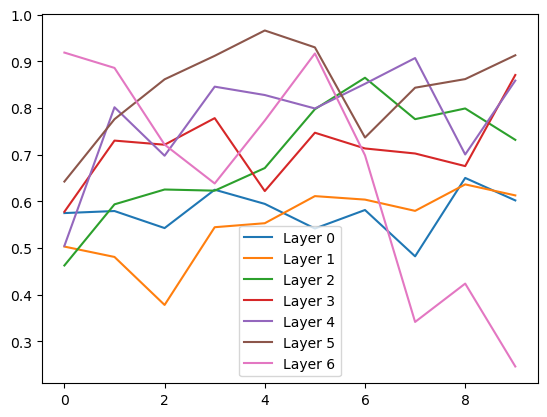

In [8]:
res = []
model = MLP(2,7,2,1)
model.eval()

for epoch in tqdm(range(999, 10000, 1000)):
    full_path = f'{models_path}/overfit/mlp_{mode}/model_{epoch}.pth'
    model.load_state_dict(torch.load(full_path))
    model.forward(torch.from_numpy(dataset.X).float(), save_activations=True)
    activations = model.activations
    if activations[-1].shape[1] == 1:
        activations = activations[:-1]
    samples = sample_layers(activations, num_samples=100)
    euclidean = get_euclideaness(activations, samples)
    res.append(euclidean)

res = np.array(res)

K = res.shape[1]
for i in range(K):
    plt.plot(res[:, i], label=f'Layer {i}')
plt.legend()
plt.savefig("figures/Euclideness_overfit.png")

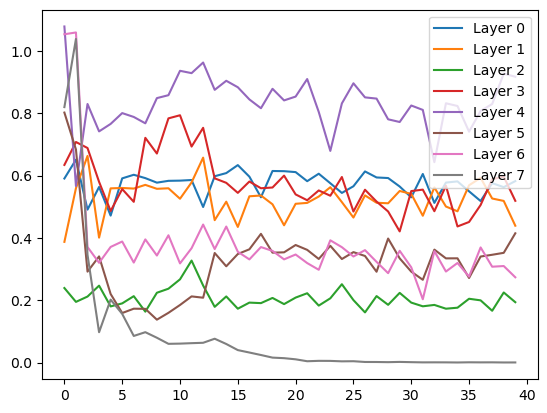